# Capstone Project: The Battle of the Neighborhoods
## IBM Applied Data Science Certificate (Coursera)

### Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Seattle is the fastest-growing big city in the United States of America. Having gained over 100,000 new residents over the past decade, it is rapidly becoming one of the key West Coast business and cultural centers.

In this project we will conduct an analysis of Seattle neighborhoods to evaluate their relative attractiveness (as reflected by median house prices) and understand the similarities between them in terms of availability of certain venues. 

There are two target customer groups for this research, each with its own need: 
* Prospective homebuyers are looking for neighborhoods with certain amenities (depending on their demographics and lifestyle) and lowest possible property prices; 
* Business owners about to open or expand a business are looking for neighborhoods with sufficiently affluent population (as reflected by median house prices) and a relative lack of competition. 




## Data <a name="data"></a>

The following data sources will be used for the research project: 
* Geographical data on Seattle neighborhoods from the Seattle Open Data program (https://data.seattle.gov). 
* Data on median housing prices for each neighborhood from Zillow using Zillow API (https://www.zillow.com/howto/api) 
* Data on various Seattle venues from Foursquare using Foursquare API (https://developer.foursquare.com/). 

First, geo data from Seattle Open Data will be used to create a map of Seattle neighborhoods. This data will then be combined with median housing prices for each neighborhood. Finally, each neighborhood will be populated with venue information from Foursquare, which will then be used for neighborhood clustering.  

### Identifying the neighborhoods

First, some preparatory steps: 

*Importing all necessary data processing, vizualization and machine learning libraries* 

In [1]:
import numpy as np # Library to handle data in a vectorized manner

import pandas as pd # Our main library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import geopandas as gpd # Library to handle geodataframes 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import clustering algorithms from scikit-learn
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import folium # map rendering library

import xml.etree.ElementTree as ET #Library to handle XML data structures
import xmltodict

#Additional libraries to handle data vizualization
import shapely
from shapely.geometry import Point
import unicodedata


print('Libraries imported.')

Libraries imported.


*Now we'll define several functions to be used for neighborhood classification*

In [2]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [3]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Seattle Open Data Program provides all information on the city neighborhoods, including boundary data, in a convenient GeoJSON format: 

In [5]:
!wget -q -O seattle_data.json http://data-seattlecitygis.opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.geojson

print('Data downloaded!')

Data downloaded!


We will use GeoPandas as the main library for geospatial data, as it'll allow us to store neighborhood boundary data (geometry) directly in the dataframe.

In [6]:
seattle_data = gpd.read_file('seattle_data.json')
seattle_data.head()

,OBJECTID,PERIMETER,S_HOOD,L_HOOD,L_HOODID,SYMBOL,SYMBOL2,AREA,HOODS_,HOODS_ID,SHAPE_Length,SHAPE_Area,geometry
0,1,617.843,OOO,,0,0,0,3588.443,2,0,617.842614,3588.442385,POLYGON ((-122.2739789529401 47.69522647266365...
1,2,733.568,OOO,,0,0,0,22294.777,3,0,733.568416,22294.781706,POLYGON ((-122.2875597861967 47.64522740482133...
2,3,4088.442,OOO,,0,0,0,56695.367,5,0,4088.441739,56695.357490,"POLYGON ((-122.3952908582123 47.6651350445393,..."
3,4,1809.446,OOO,,0,0,0,64156.813,6,0,1809.445748,64156.821780,POLYGON ((-122.3983207858678 47.66608770690774...
4,5,250.330,OOO,,0,0,0,2993.164,7,0,250.330362,2993.161328,POLYGON ((-122.2885127664106 47.65630022774357...


Information on median housing prices for each neighborhood will be obtained from Zillow using their API: 

In [7]:
urlz = 'http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz1h38gdvze2z_3z9zt&state=wa&city=seattle&childtype=neighborhood'

results = requests.get(urlz)


In [8]:
zillow = open("zillow.xml", "w")
zillow.write(results.text)
zillow.close()

Zillow API generates an XML file, which we'll convert into a dictionary, and then into a dataframe. 

In [9]:
with open('zillow.xml', 'r') as f:
    data = xmltodict.parse(f.read())['RegionChildren:regionchildren']['response']['list']['region']

df = pd.DataFrame(data)
df.head()

,id,name,zindex,url,latitude,longitude
0,250206,Capitol Hill,"{'@currency': 'USD', '#text': '415600'}",http://www.zillow.com/local-info/WA-Seattle/Ca...,47.62622,-122.315979
1,272001,University District,"{'@currency': 'USD', '#text': '514200'}",http://www.zillow.com/local-info/WA-Seattle/Un...,47.66073,-122.305045
2,271990,Magnolia,"{'@currency': 'USD', '#text': '662000'}",http://www.zillow.com/local-info/WA-Seattle/Ma...,47.650943,-122.409136
3,250788,Greenwood,"{'@currency': 'USD', '#text': '421400'}",http://www.zillow.com/local-info/WA-Seattle/Gr...,47.694211,-122.355289
4,252248,Wallingford,"{'@currency': 'USD', '#text': '608500'}",http://www.zillow.com/local-info/WA-Seattle/Wa...,47.658763,-122.334464


Now we need to extract the median house price from a dictionary into a separate column, and drop data we won't need anymore. 

In [10]:
dff = df['zindex'].apply(pd.Series)
df['Median Price'] = dff['#text']
df.drop(['zindex','id','url'],axis=1, inplace=True)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexes/api.py:57: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  union = _union_indexes(indexes)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  result = result.union(other)


We drop unnecessary data from the neighborhood geodataframe, as well...  

In [11]:
seattle_data.drop(['OBJECTID','PERIMETER','L_HOOD', 'L_HOODID','SYMBOL','SYMBOL2','AREA','HOODS_','HOODS_ID','SHAPE_Length','SHAPE_Area'], axis=1, inplace=True)
seattle_data = seattle_data[seattle_data.S_HOOD != 'OOO']

... and perform a right join on both dataframes. 

In [12]:
result = pd.merge(df, seattle_data, left_on='name', right_on='S_HOOD', how='right')

Zillow does not have pricing data on some neighborhoods, so we'll calculate the average house price for Seattle and apply it to fill the missing values. 

In [13]:
result['Median Price'] = result['Median Price'].astype(float)
meanprice = result['Median Price'].mean(skipna=True)
result.fillna(0, inplace=True)
result.name = result.name.astype(str)
meanprice = int(meanprice)
result.replace(0, meanprice, inplace=True)
result['Median Price'] = result['Median Price'].astype(int)
result.insert(0, 'Neighborhood', result['S_HOOD'])


Finally, we convert the merged dataframe to GeoDataFrame format, calculate centroids for each neighborhood (we'll need them later to place markers on the map), drop unnecessary columns and initialize WGS84 projection for our geospatial data. 

In [14]:
result = gpd.GeoDataFrame(result, geometry='geometry')
result.crs = {'init' :'epsg:4326'}
result['Latitude'] = result.centroid.y
result['Longitude'] = result.centroid.x
result.drop('latitude', axis=1, inplace=True)
result.drop('longitude', axis=1, inplace=True)
result.drop('S_HOOD', axis=1, inplace=True)
result.drop('name', axis=1, inplace=True)
result.replace(' ', 'Unknown', inplace=True)

In [15]:
result.head()

,Neighborhood,Median Price,geometry,Latitude,Longitude
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774


Now it's time to query venue data for each neighborhood from Foursquare using a function defined earlier. 

*(Foursquare credentials are provided in the hidden cell below)*

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
seattle_venues = getNearbyVenues(names=result['Neighborhood'],
                                   latitudes=result['Latitude'],
                                   longitudes=result['Longitude'],
                                   radius=radius)

This concludes the data gathering phase. To recap, we have a GeoPandas geodataframe with all neighborhood information we need:

In [18]:
result.head()

,Neighborhood,Median Price,geometry,Latitude,Longitude
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774


... and a regular Pandas dataframe with a list of venues in each neighborhood: 

In [19]:
seattle_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,University District,47.659728,-122.308346,Sweet Alchemy Ice Cream,47.659877,-122.313242,Ice Cream Shop
1,University District,47.659728,-122.308346,Shawarma King,47.660923,-122.313199,Mediterranean Restaurant
2,University District,47.659728,-122.308346,Pink Gorilla,47.661026,-122.313238,Video Game Store
3,University District,47.659728,-122.308346,Sizzle&Crunch,47.658331,-122.313561,Vietnamese Restaurant
4,University District,47.659728,-122.308346,Neptune Theatre,47.661105,-122.313995,Music Venue


## Methodology <a name="methodology"></a>

We will show Seattle neighborhoods on the map using boundary data from the Seattle Open Data project, and add a choropleth layer to show housing prices for each neighborhood. We will then create features based on different venue categories obtained from Foursquare, and apply several machine learning techniques to identify neighborhood clusters. 


### Data Visualization

First, let's initialize the map: 

In [20]:
seattle_map = folium.Map(location=[47.60,-122.33], zoom_start=12, tiles='OpenStreetMap')
seattle_map

We then create a choropleth layer using the median house prices as the statistical variable: 

In [21]:
folium.Choropleth(geo_data = result.to_json(),
    data=result,
    columns=['Neighborhood','Median Price'],
    key_on='feature.properties.Neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Seattle Neighborhoods'
).add_to(seattle_map)

seattle_map.save("neighborhoods.html")


The next step of our analysis is to classify all neighborhoods by venue availability. We will use a k-means clustering machine learning algorithm to identify any potential patterns. 

### Feature Selection

We will use venue categories as features for the model. First, we'll encode them using one-hot scheme: 

In [22]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")
seattle_onehot.drop('Neighborhood', axis=1, inplace=True)

# add neighborhood column back to dataframe
seattle_onehot.insert(0,'Neighborhood', seattle_venues['Neighborhood'])

seattle_onehot.head()

,Neighborhood,ATM,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Club,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Track,Trade School,Trail,Train Station,Tunnel,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,University District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
print(seattle_grouped.shape)
seattle_grouped.head()

(89, 276)


,Neighborhood,ATM,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Club,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Track,Trade School,Trail,Train Station,Tunnel,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.034091,0.0,0.045455,0.0,0.0,0.0,0.0,0.00,0.011364,

There are 276 venue categories, which we will use as features for the model. The dataframe 'seattle_grouped_clustering' will be used to store mean values for each venue category and neighborhood. 

In [26]:
seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

Let's also create a new dataframe with top 10 venues for each neighborhood, which we will use to interpret results. 

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Mexican Restaurant,Cocktail Bar,Ice Cream Shop,Coffee Shop,Burger Joint,Bar,Vietnamese Restaurant,Sushi Restaurant,Bakery,BBQ Joint
1,Alki,Trail,Boarding House,Park,Scenic Lookout,Playground,Brewery,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
2,Arbor Heights,BBQ Joint,Music Venue,Zoo Exhibit,Field,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
3,Atlantic,Bus Station,Scenic Lookout,Rental Service,Trail,Skate Park,Tunnel,Dry Cleaner,Park,Café,South American Restaurant
4,Belltown,Bar,Coffee Shop,Bakery,Sushi Restaurant,Pizza Place,Cocktail Bar,Breakfast Spot,Hotel,New American Restaurant,Middle Eastern Restaurant


## Analysis <a name="analysis"></a>

Now we will run several machine learning algorithms to identify neighborhood clusters and see if we can get any useful insights from this data.

### K-Means Clustering

First, let's try to find the optimal k for the k-means clustering algorithm using the elbow method: 

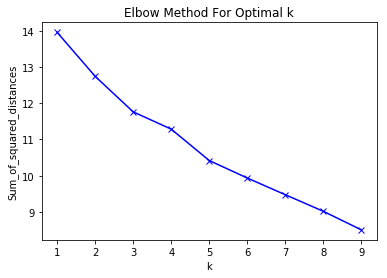

In [28]:
Sum_of_squared_distances = []

K = range(1,10)
for k in K:
    km = KMeans(init = 'k-means++', n_clusters=k, n_init=12)
    km = km.fit(seattle_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Although there is no clear elbow, we will set the number of clusters to 4: 

In [29]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(init = 'k-means++', n_clusters=kclusters, n_init=12, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Creating a merged dataframe, containing 10 most common venue categories for each neighborhood, as well as the cluster label: 

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'K-Means Cluster Labels', kmeans.labels_)

seattle_merged = result

seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.dropna(inplace=True)
seattle_merged['K-Means Cluster Labels'] = seattle_merged['K-Means Cluster Labels'].astype(int)

seattle_merged.head()

,Neighborhood,Median Price,geometry,Latitude,Longitude,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346,1,Coffee Shop,Thai Restaurant,Vietnamese Restaurant,Sandwich Place,Mediterranean Restaurant,Asian Restaurant,Bubble Tea Shop,Japanese Restaurant,Café,Middle Eastern Restaurant
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316,1,Coffee Shop,Mexican Restaurant,Bar,Playground,Bookstore,Café,Middle Eastern Restaurant,French Restaurant,Cheese Shop,Karaoke Bar
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068,1,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bookstore,Burger Joint,Ice Cream Shop,Pub,Bus Line,Bank
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789,1,Park,American Restaurant,Coffee Shop,Bookstore,Mexican Restaurant,Burger Joint,Food,Board Shop,Seafood Restaurant,Caribbean Restaurant
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774,1,Mexican Restaurant,Coffee Shop,Café,Brewery,Light Rail Station,Sandwich Place,Bakery,Gas Station,Taco Place,Food Truck


#### Finally, let's show the clusters on the neighborhood map, and print out neighborhood distribution by cluster: 

In [31]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['K-Means Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(seattle_map)
       
seattle_map.save("kmeans_clusters.html")

In [32]:
for i in range(kclusters):
    print('Label color: ', rainbow[i-1])
    print('Number of neighborhoods in cluster: ', seattle_merged['Neighborhood'].loc[seattle_merged['K-Means Cluster Labels'] == i].count())   
    nbhood = seattle_merged.loc[seattle_merged['K-Means Cluster Labels'] == i, seattle_merged.columns[[0] + [1] + list(range(6, seattle_merged.shape[1]))]]
    display(nbhood.sort_values(by='Median Price', ascending=False))


Label color:  #ff0000
Number of neighborhoods in cluster:  16


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,East Queen Anne,667300,Playground,Park,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
57,View Ridge,656000,Food Truck,Park,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Field
50,Leschi,624600,Playground,Park,Pet Store,Grocery Store,American Restaurant,Pizza Place,Event Space,Dry Cleaner,Dumpling Restaurant,Electronics Store
12,Green Lake,573500,Park,Lake,Trail,Theater,Playground,Bed & Breakfast,Beach,Falafel Restaurant,Electronics Store,Ethiopian Restaurant
32,Alki,568600,Trail,Boarding House,Park,Scenic Lookout,Playground,Brewery,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
48,Fauntleroy,535900,Park,Construction & Landscaping,Market,Bakery,Dance Studio,American Restaurant,Pilates Studio,Ethiopian Restaurant,Event Space,Falafel Restaurant
67,Lawton Park,488253,Park,Massage Studio,Playground,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fondue Restaurant,Drugstore
70,Briarcliff,488253,Bus Stop,Park,Scenic Lookout,Zoo Exhibit,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
88,Mount Baker,488253,Park,Harbor / Marina,Pet Store,Pizza Place,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Zoo Exhibit
90,Unknown,488253,Park,Beach,History Museum,Restaurant,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant


Label color:  #8000ff
Number of neighborhoods in cluster:  73


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Laurelhurst,1070400,Pharmacy,Park,Music Venue,Coffee Shop,Café,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
71,Madison Park,988600,Golf Course,Coffee Shop,Soccer Field,Playground,Track,Filipino Restaurant,Field,Fast Food Restaurant,Fish & Chips Shop,Farmers Market
74,Windermere,967300,Auto Workshop,Beach,Field,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Zoo Exhibit
63,Montlake,829800,Bus Stop,Salon / Barbershop,Grocery Store,Coffee Shop,Park,American Restaurant,Italian Restaurant,Antique Shop,Bus Line,Bike Shop
75,Portage Bay,778300,Bus Stop,Deli / Bodega,Art Gallery,Sushi Restaurant,Playground,Mexican Restaurant,Café,Zoo Exhibit,Ethiopian Restaurant,Event Space
27,West Queen Anne,703100,Scenic Lookout,Café,Dive Bar,Ice Cream Shop,Sandwich Place,Rental Car Location,Coffee Shop,Italian Restaurant,Donut Shop,Jewelry Store
53,Madrona,695800,Gift Shop,Food & Drink Shop,Italian Restaurant,Coffee Shop,Seafood Restaurant,Ethiopian Restaurant,Park,Asian Restaurant,Turkish Restaurant,French Restaurant
9,North Queen Anne,658000,ATM,Burger Joint,Bagel Shop,Soccer Field,Sandwich Place,Restaurant,Harbor / Marina,Tennis Court,Dumpling Restaurant,Electronics Store
40,Sunset Hill,612800,Harbor / Marina,Food Truck,Playground,Outdoor Sculpture,Park,Coffee Shop,Gas Station,Board Shop,Post Office,Boat or Ferry
2,Wallingford,608500,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bookstore,Burger Joint,Ice Cream Shop,Pub,Bus Line,Bank


Label color:  #2adddd
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Matthews Beach,556700,Gym,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Drugstore


Label color:  #d4dd80
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Olympic Hills,365200,Pool,Zoo Exhibit,Fast Food Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Field


Using k-means, we have obtained one cluster of 16 neighborhoods, one cluster of 73 neighborhoods, and two clusters of one neighborhood each. Let's try several other clustering methods to see if we can find a better model. 

### Agglomerative (Hierarchical) Clustering

In [33]:
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'average')

In [34]:
agglom.fit(seattle_grouped_clustering)
len(set(agglom.labels_))

4

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Agglom Cluster Labels', agglom.labels_)

seattle_merged = result

seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.dropna(inplace=True)
seattle_merged['Agglom Cluster Labels'] = seattle_merged['Agglom Cluster Labels'].astype(int)

seattle_merged.head()

,Neighborhood,Median Price,geometry,Latitude,Longitude,Agglom Cluster Labels,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346,0,1.0,Coffee Shop,Thai Restaurant,Vietnamese Restaurant,Sandwich Place,Mediterranean Restaurant,Asian Restaurant,Bubble Tea Shop,Japanese Restaurant,Café,Middle Eastern Restaurant
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316,0,1.0,Coffee Shop,Mexican Restaurant,Bar,Playground,Bookstore,Café,Middle Eastern Restaurant,French Restaurant,Cheese Shop,Karaoke Bar
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068,0,1.0,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bookstore,Burger Joint,Ice Cream Shop,Pub,Bus Line,Bank
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789,0,1.0,Park,American Restaurant,Coffee Shop,Bookstore,Mexican Restaurant,Burger Joint,Food,Board Shop,Seafood Restaurant,Caribbean Restaurant
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774,0,1.0,Mexican Restaurant,Coffee Shop,Café,Brewery,Light Rail Station,Sandwich Place,Bakery,Gas Station,Taco Place,Food Truck


In [36]:
seattle_map = folium.Map(location=[47.60,-122.33], zoom_start=12, tiles='OpenStreetMap')

In [37]:
folium.Choropleth(geo_data = result.to_json(),
    data=result,
    columns=['Neighborhood','Median Price'],
    key_on='feature.properties.Neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Seattle Neighborhoods'
).add_to(seattle_map)

In [38]:
x = np.arange(len(set(agglom.labels_)))
ys = [i + x + (i*x)**2 for i in range(len(set(agglom.labels_)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Agglom Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(seattle_map)
       
seattle_map.save("agglom_clusters.html")

In [39]:
for i in range(kclusters):
    print('Label color: ', rainbow[i-1])
    print('Number of neighborhoods in cluster: ', seattle_merged['Neighborhood'].loc[seattle_merged['Agglom Cluster Labels'] == i].count())   
    nbhood = seattle_merged.loc[seattle_merged['Agglom Cluster Labels'] == i, seattle_merged.columns[[0] + [1] + list(range(6, seattle_merged.shape[1]))]]
    display(nbhood.sort_values(by='Median Price', ascending=False))


Label color:  #ff0000
Number of neighborhoods in cluster:  88


,Neighborhood,Median Price,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Laurelhurst,1070400,1.0,Pharmacy,Park,Music Venue,Coffee Shop,Café,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
71,Madison Park,988600,1.0,Golf Course,Coffee Shop,Soccer Field,Playground,Track,Filipino Restaurant,Field,Fast Food Restaurant,Fish & Chips Shop,Farmers Market
63,Montlake,829800,1.0,Bus Stop,Salon / Barbershop,Grocery Store,Coffee Shop,Park,American Restaurant,Italian Restaurant,Antique Shop,Bus Line,Bike Shop
75,Portage Bay,778300,1.0,Bus Stop,Deli / Bodega,Art Gallery,Sushi Restaurant,Playground,Mexican Restaurant,Café,Zoo Exhibit,Ethiopian Restaurant,Event Space
27,West Queen Anne,703100,1.0,Scenic Lookout,Café,Dive Bar,Ice Cream Shop,Sandwich Place,Rental Car Location,Coffee Shop,Italian Restaurant,Donut Shop,Jewelry Store
53,Madrona,695800,1.0,Gift Shop,Food & Drink Shop,Italian Restaurant,Coffee Shop,Seafood Restaurant,Ethiopian Restaurant,Park,Asian Restaurant,Turkish Restaurant,French Restaurant
20,East Queen Anne,667300,0.0,Playground,Park,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
9,North Queen Anne,658000,1.0,ATM,Burger Joint,Bagel Shop,Soccer Field,Sandwich Place,Restaurant,Harbor / Marina,Tennis Court,Dumpling Restaurant,Electronics Store
57,View Ridge,656000,0.0,Food Truck,Park,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Field
50,Leschi,624600,0.0,Playground,Park,Pet Store,Grocery Store,American Restaurant,Pizza Place,Event Space,Dry Cleaner,Dumpling Restaurant,Electronics Store


Label color:  #8000ff
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Windermere,967300,1.0,Auto Workshop,Beach,Field,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Zoo Exhibit


Label color:  #2adddd
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Matthews Beach,556700,2.0,Gym,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Drugstore


Label color:  #d4dd80
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Olympic Hills,365200,3.0,Pool,Zoo Exhibit,Fast Food Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Field


Using agglomerative clustering, we have obtained one cluster of 88 neighborhoods, and three clusters of one neighborhood each. This is clearly a less useful model than the one created by k-means clustering, but let's try the DBSCAN algorithm as well. 

### DBSCAN

In [40]:
dbscan = DBSCAN(metric='euclidean').fit(seattle_grouped_clustering)

In [41]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
len(set(dbscan.labels_))

2

In [42]:
neighborhoods_venues_sorted.insert(0, 'DBSCAN Cluster Labels', dbscan.labels_)

seattle_merged = result

seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.dropna(inplace=True)
seattle_merged['DBSCAN Cluster Labels'] = seattle_merged['DBSCAN Cluster Labels'].astype(int)
seattle_merged['DBSCAN Cluster Labels'].replace(-1, 1, inplace=True)

seattle_merged.head()

,Neighborhood,Median Price,geometry,Latitude,Longitude,DBSCAN Cluster Labels,Agglom Cluster Labels,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346,0,0.0,1.0,Coffee Shop,Thai Restaurant,Vietnamese Restaurant,Sandwich Place,Mediterranean Restaurant,Asian Restaurant,Bubble Tea Shop,Japanese Restaurant,Café,Middle Eastern Restaurant
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316,0,0.0,1.0,Coffee Shop,Mexican Restaurant,Bar,Playground,Bookstore,Café,Middle Eastern Restaurant,French Restaurant,Cheese Shop,Karaoke Bar
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068,0,0.0,1.0,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bookstore,Burger Joint,Ice Cream Shop,Pub,Bus Line,Bank
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789,0,0.0,1.0,Park,American Restaurant,Coffee Shop,Bookstore,Mexican Restaurant,Burger Joint,Food,Board Shop,Seafood Restaurant,Caribbean Restaurant
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774,0,0.0,1.0,Mexican Restaurant,Coffee Shop,Café,Brewery,Light Rail Station,Sandwich Place,Bakery,Gas Station,Taco Place,Food Truck


In [43]:
seattle_map = folium.Map(location=[47.60,-122.33], zoom_start=12, tiles='OpenStreetMap')
folium.Choropleth(geo_data = result.to_json(),
    data=result,
    columns=['Neighborhood','Median Price'],
    key_on='feature.properties.Neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Seattle Neighborhoods'
).add_to(seattle_map)

In [44]:
x = np.arange(len(set(dbscan.labels_)))
ys = [i + x + (i*x)**2 for i in range(len(set(dbscan.labels_)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['DBSCAN Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(seattle_map)
       
seattle_map.save("dbscan_clusters.html")

In [45]:
for i in range(len(set(dbscan.labels_))):
    print('Label color: ', rainbow[i-1])
    print('Number of neighborhoods in cluster: ', seattle_merged['Neighborhood'].loc[seattle_merged['DBSCAN Cluster Labels'] == i].count())   
    nbhood = seattle_merged.loc[seattle_merged['DBSCAN Cluster Labels'] == i, seattle_merged.columns[[0] + [1] + list(range(6, seattle_merged.shape[1]))]]
    display(nbhood.sort_values(by='Median Price', ascending=False))


Label color:  #ff0000
Number of neighborhoods in cluster:  79


,Neighborhood,Median Price,Agglom Cluster Labels,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Laurelhurst,1070400,0.0,1.0,Pharmacy,Park,Music Venue,Coffee Shop,Café,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
71,Madison Park,988600,0.0,1.0,Golf Course,Coffee Shop,Soccer Field,Playground,Track,Filipino Restaurant,Field,Fast Food Restaurant,Fish & Chips Shop,Farmers Market
63,Montlake,829800,0.0,1.0,Bus Stop,Salon / Barbershop,Grocery Store,Coffee Shop,Park,American Restaurant,Italian Restaurant,Antique Shop,Bus Line,Bike Shop
75,Portage Bay,778300,0.0,1.0,Bus Stop,Deli / Bodega,Art Gallery,Sushi Restaurant,Playground,Mexican Restaurant,Café,Zoo Exhibit,Ethiopian Restaurant,Event Space
27,West Queen Anne,703100,0.0,1.0,Scenic Lookout,Café,Dive Bar,Ice Cream Shop,Sandwich Place,Rental Car Location,Coffee Shop,Italian Restaurant,Donut Shop,Jewelry Store
53,Madrona,695800,0.0,1.0,Gift Shop,Food & Drink Shop,Italian Restaurant,Coffee Shop,Seafood Restaurant,Ethiopian Restaurant,Park,Asian Restaurant,Turkish Restaurant,French Restaurant
20,East Queen Anne,667300,0.0,0.0,Playground,Park,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
9,North Queen Anne,658000,0.0,1.0,ATM,Burger Joint,Bagel Shop,Soccer Field,Sandwich Place,Restaurant,Harbor / Marina,Tennis Court,Dumpling Restaurant,Electronics Store
50,Leschi,624600,0.0,0.0,Playground,Park,Pet Store,Grocery Store,American Restaurant,Pizza Place,Event Space,Dry Cleaner,Dumpling Restaurant,Electronics Store
40,Sunset Hill,612800,0.0,1.0,Harbor / Marina,Food Truck,Playground,Outdoor Sculpture,Park,Coffee Shop,Gas Station,Board Shop,Post Office,Boat or Ferry


Label color:  #8000ff
Number of neighborhoods in cluster:  12


,Neighborhood,Median Price,Agglom Cluster Labels,K-Means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Windermere,967300,1.0,1.0,Auto Workshop,Beach,Field,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Zoo Exhibit
57,View Ridge,656000,0.0,0.0,Food Truck,Park,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Field
72,Seward Park,590400,0.0,1.0,Arts & Crafts Store,Burger Joint,Beach,Zoo Exhibit,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Field
42,Matthews Beach,556700,2.0,2.0,Gym,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Drugstore
16,Broadview,518100,0.0,1.0,Trail,Art Gallery,Drugstore,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
51,Seaview,470700,0.0,1.0,Gym,Night Market,Insurance Office,Speakeasy,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
26,North College Park,388200,0.0,0.0,Advertising Agency,Community College,College Theater,Park,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
45,Arbor Heights,385500,0.0,1.0,BBQ Joint,Music Venue,Zoo Exhibit,Field,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
18,Olympic Hills,365200,3.0,3.0,Pool,Zoo Exhibit,Fast Food Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Field
65,Riverview,325300,0.0,0.0,Playground,Bakery,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Zoo Exhibit


Using DBSCAN, we have obtained one cluster of 79 neighborhoods, and 12 outliers. This also seems a less useful output compared to k-means clustering. 

## Results and Discussion <a name="results"></a>

Out of the three algorithms applied to the model, k-means clustering seems to provide the most meaningful result, so we will use it to interpret data. 

The first cluster (73 neighborhoods) comprises the majority of Seattle, and is characterized by a mix of urban venues: coffee shops, bars, various restaurants and grocery chains. These neighborhoods also feature public transit infrastructure (bus stops and light rail stations). 

Variance in housing prices within this cluster is substantial: from over 1 million in Laurelhurst to sub-300 thousand in neighborhoods like Rainier Beach, Highland Park and Dunlap. Most neighborhoods on the lower end of the spectrum are rapidly gentrifying, with newly constructed townhomes dominating the residential market. Families looking to move into Seattle are likely to consider these neighborhoods as their first choice. 

The second cluster (16 neighborhoods) is characterized by close proximity to parks, trails and playgrounds. Unsurprisingly, being quiet residential areas that they are, these neighborhoods tend to be located off city center, with 6 neighborhoods in North Seattle, 6 in West Seattle, and two in South Seattle. 

The most expensive neighborhoods in this cluster are East Queen Anne, View Ridge and Leschi: all old, established neighborhoods with plenty of single-family homes. On the other hand, neighborhoods like Riverview, South Park and High Point present a similar mix of amenities, yet have much lower housing prices on average, and as such may be appealing to families looking at inexpensive homes with close proximity to parks. 


It is interesting to look at the two outliers generated by the model. 

Matthews Beach and Olympic Hills are two neighborhoods in North Seattle. WIth median house prices of 556,700 and 365,200, respectively, and relative proximity to the University of Washington, they seem to be attractive destinations for prospective homeowners. Both have access to parks, gyms and pools, and yet seem to be lacking in venues that distinguish neighborhoods in immediate proximity: e.g. coffee shops, bars and cafes. This present a potential opportunity for business owners looking to expand into new neighborhoods. 



## Conclusion <a name="conclusion"></a>

This model leaves ample room for improvement and refinement. 

First of all, model accuracy can be significantly improved by better feature selection. Currently, all venue data from Foursquare is treated equally, without any attempt at categorization. It might make sense to separate venues into public amenities and transit, and commercial venues. 

Second, a better algorithm to select venues by neighborhood can be implemented. Right now, the algorithm pulls all venues within a 500-meter radius of each neighborhood's centroid; it would be better to consider a more accurate approach: 

* Create a grid of evenly spaced points (e.g. 100 meters apart) spanning the entire area of Seattle;
* Allocate each point to one neighborhood based on boundary data; 
* Run a Foursquare query for each point, so that the entire area is covered by overlapping circles; 
* Remove duplicate results; 
* Assign venues to each neighborhood. 

Third, incorporating other data sources (e.g. crime statistics and school ratings) would present a much better picture of each neighborhood's desirability. 

Finally, expanding the model to the greater Seattle area (including Renton, Bellevue, Redmond, etc.) would greatly increase its practical value. However, these municipalities may not have neighborhood data as readily available as Seattle, so further research into data collection is needed.

Nevertheless, even in its most basic form, this model provides some interesting insights into the Seattle neighborhoods. 

